In [40]:
import os
os.chdir("/Users/mustafa/Documents/grad school/spring 2024/ECE285 - Visual Learning/PointCloudPosePrediction")
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import open3d as o3d
from scipy.io import loadmat
from scipy.spatial.transform import Rotation as R
import tqdm
from typing import Any, Callable, Optional, Tuple
from enum import Enum
import yaml
import cv2
import matplotlib.pyplot as plt
import core.pointnet as pnet
from utils.dataloader import EdenDataset

In [2]:
# load params for current model run; choose model run below after creating yaml file for it
with open("./models/run_1.yaml") as f:
    params = yaml.safe_load(f)

In [41]:
# create data loader for Eden data - outputs pairs of point clouds and relative poses
edenLoader = DataLoader(dataset=EdenDataset("/Users/mustafa/Documents/grad school/spring 2024/ECE285 - Visual Learning/eden/sample"), 
                        batch_size=64, shuffle=True, num_workers=1)

In [42]:
# im = o3d.io.read_image("/Users/mustafa/Documents/grad school/spring 2024/ECE285 - Visual Learning/eden/sample/rgb/0001/clear/A_0001_L.png")
# mat = loadmat("/Users/mustafa/Documents/grad school/spring 2024/ECE285 - Visual Learning/eden/sample/poses/0001/clear/A_0001.mat")
# mat2 = loadmat("/Users/mustafa/Documents/grad school/spring 2024/ECE285 - Visual Learning/eden/sample/poses/0001/clear/A_0002.mat")
# mat["RT_L"], mat2["RT_L"]

# data = EdenDataset("/Users/mustafa/Documents/grad school/spring 2024/ECE285 - Visual Learning/eden/sample")
# data[0][0].transpose(1,0)
batch = next(iter(edenLoader))

### Keypoint detection to downsample point cloud

In [24]:
class KeyPointDetectorType(Enum):
    ORB = 1
    SIFT = 2

class KeyPointDetector:

    def __init__(self) -> None:
        self.router : dict = {"ORB":self.orb, "SIFT":self.sift, "FPFH":self.fpfh}

    def process(self, keyPointAlgo : KeyPointDetectorType, img=None, pcd=None) -> Callable:
        """Takes in one of img or pcd depending on which detector to use. Routes to appropriate function"""
        if img:
            return self.router[keyPointAlgo.name](img)
        if pcd:
            return self.router[keyPointAlgo.name](pcd)
        
    def orb(self, img : np.ndarray):
        orb = cv2.ORB_create()
        kp, des = orb.detectAndCompute(img,None)
        return kp
    
    def sift(self, img : np.ndarray):
        surf = cv2.SIFT_create() 
        kp, des = surf.detectAndCompute(img,None)
        return kp
    
    def fpfh(self, pcd : o3d.geometry.PointCloud):
        pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(pcd,
        o3d.geometry.KDTreeSearchParamHybrid(radius=0.5, max_nn=100))
        return pcd_fpfh

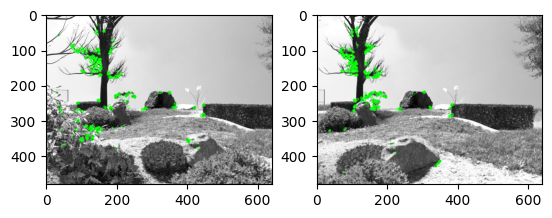

In [58]:
# visualize ORB features across images
img = cv2.imread("/Users/mustafa/Documents/grad school/spring 2024/ECE285 - Visual Learning/eden/sample/rgb/0001/clear/A_0001_L.png", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("/Users/mustafa/Documents/grad school/spring 2024/ECE285 - Visual Learning/eden/sample/rgb/0001/clear/A_0002_L.png", cv2.IMREAD_GRAYSCALE)

# Initiate ORB detector
orb = cv2.ORB_create()
 
# find the keypoints with ORB
kp = orb.detect(img,None)
kp2 = orb.detect(img2,None)
# compute the descriptors with ORB
kp, des = orb.compute(img, kp)
kp2, de2s = orb.compute(img2, kp2)

# draw only keypoints location,not size and orientation
img_key = cv2.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
img_key2 = cv2.drawKeypoints(img2, kp2, None, color=(0,255,0), flags=0)
plt.subplot(1,2,1)
plt.imshow(img_key)
plt.subplot(1,2,2)
plt.imshow(img_key2)
plt.show()

### Load PointNet and extract feature vector from point cloud

In [47]:
x, tnet_feat_input, tnet_feat_64d = pnet.PointNetfeat(global_feat = True)(batch["pcd1"].transpose(2,1))

In [ ]:
# PCA on pointNet feature vector
torch.pca_lowrank()